<center><h1>Digit Recognizer</h1></center>

<center><h3>Predicting which number a hand written digit is</h3></center>

Our aim is to develop a model which can predict which number a hand written digit represents. The accuracy of the model will be determined by the accuracy, that is, the percentage of digits that we correctly identify. The model will be used to make predictions on unlabelled test data and submitted to kaggle for evaluation.

The digits range from 0 to 9, and are given as an image of 28x28 pixels. 

We shall use Keras to build a convolution neural network which will return, for each image, the probability that it is each of the 10 numbers (e.g. we have a probability that it is 0, a probability that it is 1 etc.), and we will take the number with the highest probability to be the true number.

A great tutorial on building neural networks for this problem can be found here:
https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/

Finally, we shall also use the "committee" method of Meier et al. (http://people.idsia.ch/~juergen/icdar2011b.pdf) and fit multiple models which "vote" on which number the digit is, with the winning number being selected.

First we import the necessary modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random


import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.models import load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from scipy.stats import mode

from scipy.ndimage import morphology
from scipy import interpolate

from scipy.ndimage.filters import gaussian_filter1d
from scipy.ndimage.filters import gaussian_filter

from scipy.ndimage.interpolation import map_coordinates


import theano
#theano.config.device = 'gpu'
#theano.config.floatX = 'float32'

K.set_image_dim_ordering('th')

Using Theano backend.


This bit is needed to get theano to work, so we can run on the gpu (and speed everything up)

In [49]:
import os    
os.environ['THEANO_FLAGS'] = "mode=FAST_RUN,device=gpu,floatX=float32"    
import theano

And we read in the data, and look at the shape and what columns we have

In [3]:
df_train = pd.read_csv("train.csv")
df_test  = pd.read_csv("test.csv")
print('training data shape:    ', df_train.shape)
print('test data shape:        ', df_test.shape)
print('training data columns:  ', df_train.columns)
print('test data columns:      ', df_test.columns)

training data shape:     (42000, 785)
test data shape:         (28000, 784)
training data columns:   Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)
test data columns:       Index(['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=784)


We have 42,000 images to train on and 28,000 to test on.

Each image has 784 pixels (28 by 28), and the training data also has a label column

Now we get the maximum pixel value and the shape of the images (we have an ix by ix image)

In [4]:
num_pixels = df_test.shape[1]                           #number of pixels in the image
num_classes = df_train.label.unique().shape[0]          #number of classes (should be 10, as we have 10 different digits)
i_max = (df_train.iloc[df_train.columns != 'label'].max()).max()  #maximum intensity of the pixels
ix = int(num_pixels**0.5)                   #we have an ix by ix image

print('number of pixels:  ', num_pixels)
print('number of classes: ', num_classes)
print('maximum intensity: ', i_max)
print('minimum intensity: ', (df_train.iloc[df_train.columns != 'label'].min()).min())
print('linear size:       ', ix)

number of pixels:   784
number of classes:  10
maximum intensity:  255
minimum intensity:  0
linear size:        28


There are 10 possible classes (0,1,2,...,9)

The pixels take values from 0 to 255.

First, we make arrays of our data:

features: the intensity of the pixel, normalized by the maximum value such that they range from 0 to 1

leabels: We make an array of the labels as catagories, i.e. we have 10 digits, so we make an Nx10 array, where the elements are: 

0 - not that digit

1 - is that digit

In addition, to save memory we will give them a precision of 32bit, which is the default precision of Keras

In [5]:
features = (df_train.ix[:,df_train.columns.str.contains("ixel")].values/i_max).astype('float32')
features_test = (df_test.ix[:,df_test.columns.str.contains("ixel")].values/i_max).astype('float32')
labels = np_utils.to_categorical(df_train["label"].values).astype(int)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app


We will now write a function that can plot the digits, and write the number that it is besides it

In [50]:
def plot(digit, titles, ix = 28):
    """plot the file digit, titles is the actual number, ix is the linear size"""
    n = digit.shape[0]
    nrows = int((n+4)/5)
    ncols = 5
    digit = digit.reshape(n,ix,ix)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(1.5*ncols,1.5*nrows))
    #fig.clf()
    i = 0
    for ir in range(nrows):
        for ic in range(ncols):
            #axs[ir,ic] = fig.gca()
            axs[ir,ic].axis((0,ix-1,ix-1,0))
            axs[ir,ic].tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',         # both major and minor ticks are affected
            bottom='off',         # ticks along the bottom edge are off
            top='off',            # ticks along the top edge are off
            left='off',           # ticks along the left edge are off
            right='off',          # ticks along the right edge are off
            labelbottom='off',    # labels along the bottom edge are off
            labelleft='off')      # labels along the left edge are off
            if i < n:
                #print(titles[i], type(titles[i]))
                axs[ir,ic].set_title(titles[i].astype(str))
                axs[ir,ic].imshow(digit[i,:,:], cmap='gray_r')
            else:
                axs[ir,ic].imshow(np.zeros((ix,ix)), cmap='gray_r')
            i+=1
    plt.tight_layout()
    return 'Done'

Now we plot the first 10 digits, to see what we are dealing with

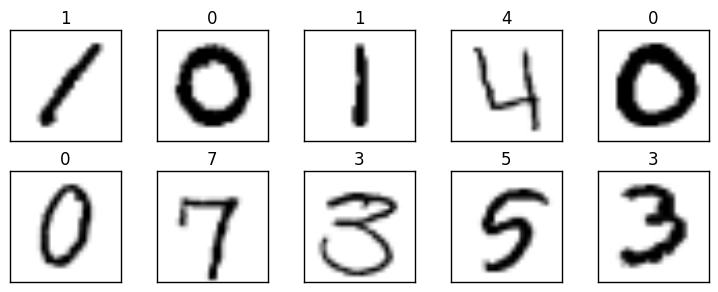

In [51]:
#for i in range(0,5):
plot(df_train.ix[:9, df_train.columns.str.contains("ixel")].values,
     df_train.ix[:9, 'label'], ix)
#
plt.show()
#print((df_train.ix[:9, 'label']).astype(str))

Now we will try a basic model to get a baseline accuracy.

We are using the Keras package and will create a model which learns on the labelled training data to predict a handwritten digit.

We first create a baseline model with the following:
 - a single hidden layer
 - the same number of neurons as there are features (784 in our case)
 - the relu activation function for the hidden layer (this tends to be faster than other activation functions)
 - the output layer has 10 (the number of classes) nodes
 - a softmax activation function on the output layer (which turns the output into a probability for each class)

We will compile the model intially using: 
 - the adam optimizer (we will test the sgd (stochastic gradient descent) later
 - categorical_crossentropy for the loss function

The model will be validated on 10% of the data which is kept aside, and the accuracy on this set will be outputted. Since the data set is large, 10% should give us a good estimate of the accuracy. 
Remember that we will get a final accuracy using the unlabbeled data that we shall submit to kaggle, hence we do not take three splits (train, test and validation).

When we predict using this model, the output will be an array of size 10 for each image, which contains the probabilities of the image being each of the numbers (e.g. we might have [0.05, 0.2, 0.6, 0.02, 0.01, 0.01, 0.01, 0.03, 0.02, 0.05], in which case the third entry, number 2, is the most likely digit, with the second entry, 1, being second most likely)

We will use 100 epochs, observing when (or if) the accuracy converges). And finally, convolution neural networks 
process the data in batches. Small batches will have much more noise, with the accuracy and loss jumping around a lot. Large batch sizes are a problem for memory. We will initially set the batch size to be 500, and return to this point later.

In [54]:
model = Sequential()
model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#split the training data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1)
#fit the model
model.fit(X_train,y_train,epochs=100,validation_data=(X_test, y_test), batch_size=500, verbose=1)
scores = model.evaluate(X_test, y_test, verbose=0)
print("Error: %.3f%%" % (scores[1]*100))

Train on 37800 samples, validate on 4200 samples
Epoch 1/100
37800/37800 [==============================] - 1s - loss: 0.4629 - acc: 0.8721 - val_loss: 0.2277 - val_acc: 0.9364
Epoch 2/100
37800/37800 [==============================] - 1s - loss: 0.1896 - acc: 0.9462 - val_loss: 0.1585 - val_acc: 0.9593
Epoch 3/100
37800/37800 [==============================] - 1s - loss: 0.1362 - acc: 0.9613 - val_loss: 0.1316 - val_acc: 0.9624
Epoch 4/100
37800/37800 [==============================] - 1s - loss: 0.1026 - acc: 0.9717 - val_loss: 0.1100 - val_acc: 0.9707
Epoch 5/100
37800/37800 [==============================] - 1s - loss: 0.0804 - acc: 0.9781 - val_loss: 0.0951 - val_acc: 0.9736
Epoch 6/100
37800/37800 [==============================] - 1s - loss: 0.0646 - acc: 0.9826 - val_loss: 0.0853 - val_acc: 0.9731
Epoch 7/100
37800/37800 [==============================] - 1s - loss: 0.0519 - acc: 0.9866 - val_loss: 0.0826 - val_acc: 0.9762
Epoch 8/100
37800/37800 [==============================

37800/37800 [==============================] - 1s - loss: 1.7824e-04 - acc: 1.0000 - val_loss: 0.0788 - val_acc: 0.9843
Epoch 64/100
37800/37800 [==============================] - 1s - loss: 1.7239e-04 - acc: 1.0000 - val_loss: 0.0791 - val_acc: 0.9838
Epoch 65/100
37800/37800 [==============================] - 1s - loss: 1.6053e-04 - acc: 1.0000 - val_loss: 0.0794 - val_acc: 0.9845
Epoch 66/100
37800/37800 [==============================] - 1s - loss: 1.5252e-04 - acc: 1.0000 - val_loss: 0.0801 - val_acc: 0.9838
Epoch 67/100
37800/37800 [==============================] - 1s - loss: 1.4632e-04 - acc: 1.0000 - val_loss: 0.0798 - val_acc: 0.9843
Epoch 68/100
37800/37800 [==============================] - 1s - loss: 1.3858e-04 - acc: 1.0000 - val_loss: 0.0802 - val_acc: 0.9840
Epoch 69/100
37800/37800 [==============================] - 1s - loss: 1.3090e-04 - acc: 1.0000 - val_loss: 0.0799 - val_acc: 0.9843
Epoch 70/100
37800/37800 [==============================] - 1s - loss: 1.2525e-04 

We get an error of about 1.6% (not bad for the first go), which appears to have saturated after about 50 epochs.

This should be different each time, even if we take the same test/train split. Let's repeat the fit

In [55]:
model = Sequential()
model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#fit the model
model.fit(X_train,y_train,epochs=100,validation_data=(X_test, y_test), batch_size=500, verbose=1)
scores = model.evaluate(X_test, y_test, verbose=0)
print("Error: %.3f%%" % (scores[1]*100))

Train on 37800 samples, validate on 4200 samples
Epoch 1/100
37800/37800 [==============================] - 1s - loss: 0.4655 - acc: 0.8714 - val_loss: 0.2301 - val_acc: 0.9343
Epoch 2/100
37800/37800 [==============================] - 1s - loss: 0.1944 - acc: 0.9447 - val_loss: 0.1678 - val_acc: 0.9548
Epoch 3/100
37800/37800 [==============================] - 1s - loss: 0.1366 - acc: 0.9613 - val_loss: 0.1300 - val_acc: 0.9660
Epoch 4/100
37800/37800 [==============================] - 1s - loss: 0.1024 - acc: 0.9725 - val_loss: 0.1107 - val_acc: 0.9700
Epoch 5/100
37800/37800 [==============================] - 1s - loss: 0.0800 - acc: 0.9775 - val_loss: 0.0970 - val_acc: 0.9733
Epoch 6/100
37800/37800 [==============================] - 1s - loss: 0.0636 - acc: 0.9838 - val_loss: 0.0890 - val_acc: 0.9745
Epoch 7/100
37800/37800 [==============================] - 1s - loss: 0.0507 - acc: 0.9871 - val_loss: 0.0841 - val_acc: 0.9748
Epoch 8/100
37800/37800 [==============================

37800/37800 [==============================] - 1s - loss: 1.7846e-04 - acc: 1.0000 - val_loss: 0.0856 - val_acc: 0.9831
Epoch 64/100
37800/37800 [==============================] - 1s - loss: 1.7038e-04 - acc: 1.0000 - val_loss: 0.0867 - val_acc: 0.9826
Epoch 65/100
37800/37800 [==============================] - 1s - loss: 1.6080e-04 - acc: 1.0000 - val_loss: 0.0862 - val_acc: 0.9833
Epoch 66/100
37800/37800 [==============================] - 1s - loss: 1.5238e-04 - acc: 1.0000 - val_loss: 0.0878 - val_acc: 0.9831
Epoch 67/100
37800/37800 [==============================] - 1s - loss: 1.4716e-04 - acc: 1.0000 - val_loss: 0.0870 - val_acc: 0.9831
Epoch 68/100
37800/37800 [==============================] - 1s - loss: 1.3828e-04 - acc: 1.0000 - val_loss: 0.0877 - val_acc: 0.9821
Epoch 69/100
37800/37800 [==============================] - 1s - loss: 1.3119e-04 - acc: 1.0000 - val_loss: 0.0874 - val_acc: 0.9831
Epoch 70/100
37800/37800 [==============================] - 1s - loss: 1.2582e-04 

Since the accuracy changes each time we fit to the data, it follows that the number we predict for certain digits is changing each time. It makes sense to do multiple runs (say we do n fits to the training data), and to average in some way. Meier et al. (http://people.idsia.ch/~juergen/icdar2011b.pdf) give three possible ways of doing this:

- Majority voting: we take the maximum probabiliy from the output of a single run for a given input as a "vote", and the number that receives the most votes from all the n runs is taken as the prediciton
- Average: average the probabilities over all the n runs, and the number with the maximum is the prediction 
- Median: for each of the 10 possible numbers, take the median value over each of the n runs, and the number with the maximum is the prediction

We will use the same test-train split here to be consistent (and so we can use these scoring systems above). We will shuffle them before each "fit", so that the neural networks see the data in a different order each time.

In [64]:
ne = 100          #the number of epochs we will use: >30 seemed to be good from our results above
nb = 500         #the batch size
split = 0.1      #the fraction of data we will use to test the model
#split the training data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=split)

In [65]:
#number of loops (i.e. number of fits to do)
n_loop = 9

#set up an array for the scores
score = np.empty(n_loop)
res = np.empty([n_loop, X_test.shape[0], num_classes])
for i in range(n_loop):
    i_n = np.random.permutation(np.arange(X_train.shape[0]))
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #fit the model
    model.fit(X_train[i_n,:],y_train[i_n,:],epochs=ne,validation_data=(X_test, y_test), batch_size=nb, verbose=0)
    res[i,:,:] = model.predict(X_test)
    scores = model.evaluate(X_test, y_test, verbose=0)
    score[i] = scores[1]*100.0
    print('Loop', i+1, 'Acc: %.3f%%' % (scores[1]*100))
  

print('')
print('Acc: %.3f%%' % (score.mean()))
print('s.d: %.3f%%' % (score.std()))

Loop 1 Acc: 97.976%
Loop 2 Acc: 97.952%
Loop 3 Acc: 97.810%
Loop 4 Acc: 97.952%
Loop 5 Acc: 97.857%
Loop 6 Acc: 97.976%
Loop 7 Acc: 97.786%
Loop 8 Acc: 97.690%
Loop 9 Acc: 97.833%

Acc: 97.870%
s.d: 0.095%


Now we will write functions that can take the res array and work out the predicted number based on the 3 schemes we outlined

In [66]:
def majority_voting(res):
    res_out = np.empty([res.shape[0], res.shape[1]])
    for i in range(res.shape[0]):
        res_out[i,:] = np.argmax(res[i,:,:], axis=1)
    return (mode(res_out[:,:])[0][0]).astype(int)
    

def mean_vote(res):
    res_out = np.mean(res,axis=0)
    return np.argmax(res_out, axis=1)
    

def median_vote(res):
    res_out = np.median(res,axis=0)
    return np.argmax(res_out, axis=1)

In [67]:
result_majority = majority_voting(res)
result_mean     = mean_vote(res)
result_median   = median_vote(res)
print(result_majority[0:5])
print(result_mean[0:5])
print(result_median[0:5])

[3 9 6 7 2]
[3 9 6 7 2]
[3 9 6 7 2]


We get the same predictions for the first five digits using each of the three methods

Now we score them all

In [68]:
def score_votes(results, labels):
    score = np.sum(np.absolute(np_utils.to_categorical(results) - labels))/2.0
    return (1.0 - score / results.shape)*100.0

In [69]:
print("majority voting: %.3f%%" % (score_votes(result_majority, y_test)))
print("mean vote:       %.3f%%" % (score_votes(result_mean, y_test)))
print("median vote:     %.3f%%" % (score_votes(result_median, y_test)))

majority voting: 98.071%
mean vote:       98.000%
median vote:     98.048%


Using the majority vote gives a score somewhat higher than the others, but not by much. Overall, we get an accuracy of about 98.0%. Note that each accuracy is only slightly above 97.87%, which was the average accuracy found for the individual fits.

Clearly, sometimes the model will predict an incorrect result even if it is, for example, 9 times out of 10 likely to get it right. Doing multiple runs and "voting" smooths this out.

A major point here: our errors will be correlated, since we are training on the same data each time. Therefore, we follow the paper by Meier et al. ("Better digit recognition with a committee of simple Neural Nets", Document Analysis and Recognition (ICDAR), 2011) and distort the images. First, we create 8 'new' training sets, 7 of which are scaled versions of the original data, such that the bounding box of the image (which we take to be the box that could be drawn around the image) is scaled to have widths of 8,10,12,14,16,18 and 20 pixels (excluding 1s, which are too narrow to do this). The final new data set comes from 'deslanting' the digits. That is, we find their principle symmetry axis, and rotate it such that it is pointing along the y-axis.

First, we write a function to scale the images.

In [29]:
def scale_width(data, label, n_scale, ix = 28):
    """scale the width of an image"""
    n = data.shape[0]
    iix = ix*ix
    digit = np.zeros([n,iix])
    for i in range(n):
        if np.argmax(label[i,:]) == 1:
            digit[i,:] = data[i,:]
        else:
            y, x = np.nonzero(data[i,:].reshape(ix,ix))
            x_t = np.tile(np.arange(ix),ix)
            y_t = np.repeat(np.arange(ix),ix)
            dx = x.max()-x.min()
            mu_x = np.mean(x)
            x_t = x_t -mu_x
            #x_t = x_t/dx * n_scale
            x_t = x_t*dx / n_scale
            x_t = x_t + mu_x
            x0 = np.floor(x_t).astype(int)
            x1 = x0 + 1
            y0 = np.floor(y_t).astype(int)
            y1 = y0 + 1
            for ii in range(x_t.shape[0]):
                if y0[ii] < 0 or y0[ii] > 27:
                    digit[i, ii] = 0.0
                elif x0[ii] < 0 or x0[ii] > 27:
                    digit[i, ii] = 0.0
                elif y1[ii] < 0 or y1[ii] > 27:
                    digit[i, ii] = 0.0
                elif x1[ii] < 0 or x1[ii] > 27:
                    digit[i, ii] = 0.0
                else:
                    Ia = data[ i, 28*y0[ii]+ x0[ii] ]
                    Ib = data[ i, 28*y1[ii]+ x0[ii] ]
                    Ic = data[ i, 28*y0[ii]+ x1[ii] ]
                    Id = data[ i, 28*y1[ii]+ x1[ii] ]
                    wa = (x1[ii]-x_t[ii]) * (y1[ii]-y_t[ii])
                    wb = (x1[ii]-x_t[ii]) * (y_t[ii]-y0[ii])
                    wc = (x_t[ii]-x0[ii]) * (y1[ii]-y_t[ii])
                    wd = (x_t[ii]-x0[ii]) * (y_t[ii]-y0[ii])
                    digit[i, ii] = wa*Ia + wb*Ib + wc*Ic + wd*Id
    return digit

And one to rotate the images

In [30]:
def align_digit(data, ix = 28):
    """rotate the digit so that its major axis is aligned along the y axis"""
    n = data.shape[0]
    iix = ix*ix
    digit = np.zeros([n,iix])
    for i in range(n):
        y, x = np.nonzero(data[i,:].reshape(ix,ix))
        x_i = np.tile(np.arange(ix),ix)
        y_i = np.repeat(np.arange(ix),ix)
        mu_x = np.mean(x)
        mu_y = np.mean(y)
        coords = np.vstack([x - mu_x, y - mu_y])
        cov = np.cov(coords)
        evals, evecs = np.linalg.eig(cov)
        sort_indices = np.argsort(evals)[::-1]
        evec1, evec2 = evecs[:, sort_indices]
        theta = np.pi/2.0 + np.arctan2(evec1[1],evec1[0])
        if theta > np.pi/2.0:
            theta = theta - np.pi
        elif theta < -np.pi/2.0:
            theta = np.pi+theta
        #print(i, theta, theta*180.0/np.pi, np.cos(theta))
        rotation_mat = np.matrix([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
        coords = np.vstack([x_i - mu_x, y_i - mu_y])
        transformed_mat = rotation_mat * coords
        x_t, y_t = transformed_mat.A
        x_t = x_t + mu_x
        y_t = y_t + mu_y
        x0 = np.floor(x_t).astype(int)
        x1 = x0 + 1
        y0 = np.floor(y_t).astype(int)
        y1 = y0 + 1
        for ii in range(x_t.shape[0]):
            if y0[ii] < 0 or y0[ii] > 27:
                digit[i, ii] = 0.0
            elif x0[ii] < 0 or x0[ii] > 27:
                digit[i, ii] = 0.0
            elif y1[ii] < 0 or y1[ii] > 27:
                digit[i, ii] = 0.0
            elif x1[ii] < 0 or x1[ii] > 27:
                digit[i, ii] = 0.0
            else:
                Ia = data[ i, 28*y0[ii]+ x0[ii] ]
                Ib = data[ i, 28*y1[ii]+ x0[ii] ]
                Ic = data[ i, 28*y0[ii]+ x1[ii] ]
                Id = data[ i, 28*y1[ii]+ x1[ii] ]
                wa = (x1[ii]-x_t[ii]) * (y1[ii]-y_t[ii])
                wb = (x1[ii]-x_t[ii]) * (y_t[ii]-y0[ii])
                wc = (x_t[ii]-x0[ii]) * (y1[ii]-y_t[ii])
                wd = (x_t[ii]-x0[ii]) * (y_t[ii]-y0[ii])
                digit[i, ii] = wa*Ia + wb*Ib + wc*Ic + wd*Id
        #if np.remainder(i+1,n/100) == 0:
        #    print(100.0*(i+1)/n, '% complete')
    return digit


In [31]:
n_loop = 9
res = np.empty([n_loop, int(split*features.shape[0]), num_classes])
scales = [8,10,12,14,16,18,20]

#set up an array for the scores
score = np.empty(n_loop)



for i in range(len(scales)):
    i_n = np.random.permutation(np.arange(X_train.shape[0]))
    X_scale_train = scale_width(X_train, y_train, scales[i], ix)
    X_scale_test = scale_width(X_test, y_test, scales[i], ix)
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #fit the model
    model.fit(X_scale_train[i_n,:],y_train[i_n,:],epochs=ne,validation_data=(X_scale_test, y_test), batch_size=nb, verbose=0)
    res[i,:,:] = model.predict(X_scale_test)
    scores = model.evaluate(X_scale_test, y_test, verbose=0)
    score[i] = scores[1]*100.0
    print('Loop: ', i+1, 'Scale: ', scales[i], 'Acc: %.3f%%' % (scores[1]*100))
    

for i in range(len(scales),len(scales)+1):
    i_n = np.random.permutation(np.arange(X_train.shape[0]))
    X_scale_train = align_digit(X_train, ix)
    X_scale_test = align_digit(X_test, ix)
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #fit the model
    model.fit(X_scale_train[i_n,:],y_train[i_n,:],epochs=ne,validation_data=(X_scale_test, y_test), batch_size=nb, verbose=0)
    res[i,:,:] = model.predict(X_scale_test)
    scores = model.evaluate(X_scale_test, y_test, verbose=0)
    score[i] = scores[1]*100.0
    print('Loop: ', i+1, 'Rotated', 'Acc: %.3f%%' % (scores[1]*100))

    
for i in range(len(scales)+1,len(scales)+2):
    i_n = np.random.permutation(np.arange(X_train.shape[0]))
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #fit the model
    model.fit(X_train[i_n,:],y_train[i_n,:],epochs=ne,validation_data=(X_test, y_test), batch_size=nb, verbose=0)
    res[i,:,:] = model.predict(X_test)
    scores = model.evaluate(X_test, y_test, verbose=0)
    score[i] = scores[1]*100.0
    print('Loop: ', i+1, 'Original', 'Acc: %.3f%%' % (scores[1]*100))

print('')
print('Acc: %.3f%%' % (score.mean()))
print('s.d: %.3f%%' % (score.std()))

Loop:  1 Scale:  8 Acc: 98.190%
Loop:  2 Scale:  10 Acc: 98.357%
Loop:  3 Scale:  12 Acc: 98.524%
Loop:  4 Scale:  14 Acc: 98.429%
Loop:  5 Scale:  16 Acc: 98.381%
Loop:  6 Scale:  18 Acc: 98.452%
Loop:  7 Scale:  20 Acc: 98.524%
Loop:  8 Rotated Acc: 97.381%
Loop:  9 Original Acc: 97.762%

Acc: 98.222%
s.d: 0.371%


In [32]:
result_majority = majority_voting(res)
result_mean     = mean_vote(res)
result_median   = median_vote(res)

print("majority voting: %.3f%%" % (score_votes(result_majority, y_test)))
print("mean vote:       %.3f%%" % (score_votes(result_mean, y_test)))
print("median vote:     %.3f%%" % (score_votes(result_median, y_test)))

majority voting: 98.619%
mean vote:       98.667%
median vote:     98.667%


We get an improvement of about 0.3% from using only the original data set. 

We can also try random deformations of the digits to remove the error still further.

For this we follow: P. Simard et al. “Best practices for convolutional neural networks applied to visual document
analysis,” in Seventh International Conference on Document Analysis and Recognition, 2003, pp. 958–963.
https://pdfs.semanticscholar.org/7b1c/c19dec9289c66e7ab45e80e8c42273509ab6.pdf

We use a guassian filter with standard deviation sigma to calculate the displacements, and scale the values by alpha.

Below we plot such a distortion field.

0.0302173898923 0.0303914222092
(784,) (784,)


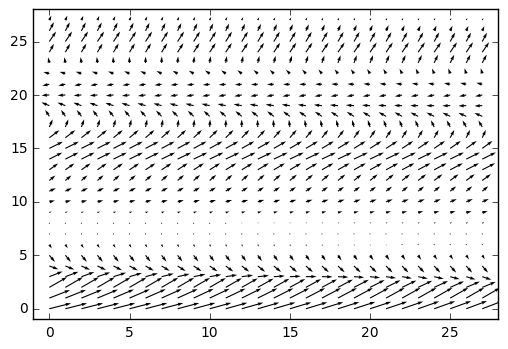

In [33]:
sigma = 36.0
alpha = 6.0
iii = 28
for i in range(1):
    dx = np.random.uniform(-1,1,(iii,iii))
    dy = np.random.uniform(-1,1,(iii,iii))
    #print(x.shape, dx.shape, data[i,:].reshape(ix,ix).shape )
    ddx = gaussian_filter(dx, sigma)*alpha
    ddy = gaussian_filter(dy, sigma)*alpha
    print(ddx.min(), ddx.max())
#print(ddy.min(), ddy.max())

x_i = np.tile(np.arange(ix),ix)
y_i = np.repeat(np.arange(ix),ix)
x, y = np.meshgrid(np.arange(ix), np.arange(ix))
ddx_i = np.random.uniform(-1,1,x_i.shape[0])
ddy_i = np.random.uniform(-1,1,x_i.shape[0])
print(x_i.shape, ddx_i.shape)
plt.quiver(x_i, y_i, gaussian_filter(ddx_i, sigma)*alpha, gaussian_filter(ddy_i, sigma)*alpha)
plt.axis([-1, 28, -1, 28])
plt.show()

In [34]:
def random_distortion(data, alpha, sigma, ix = 28):
    """distort images"""
    n = data.shape[0]
    iix = ix*ix
    digit = np.zeros([n,iix])
    for i in range(n):
        x, y = np.meshgrid(np.arange(ix), np.arange(ix))
        dx = np.random.uniform(-1,1,(ix,ix))
        dy = np.random.uniform(-1,1,(ix,ix))
        ddx = gaussian_filter(dx, sigma, mode='constant', cval=0)*alpha
        ddy = gaussian_filter(dy, sigma, mode='constant', cval=0)*alpha
        x = (x + ddx).reshape(-1,1)
        y = (y + ddy).reshape(-1,1)
        indices = np.transpose(np.hstack([y,x]))
        digit[i,:] = map_coordinates(data[i,:].reshape(ix,ix) , indices, order=1).reshape(iix)
    return digit

We now plot the first 10 digits in X_train, both distorted and the original. 

We shall use paramters of sigma = 6 and alpha = 36, again following Meier et al.

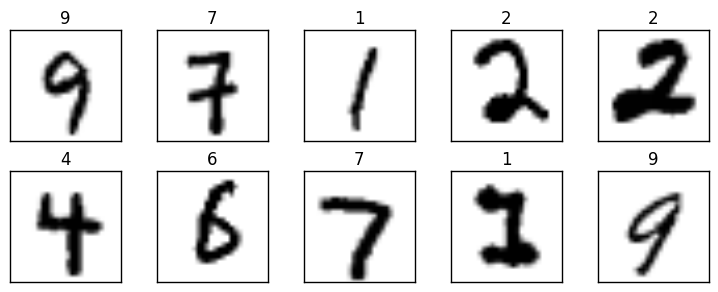

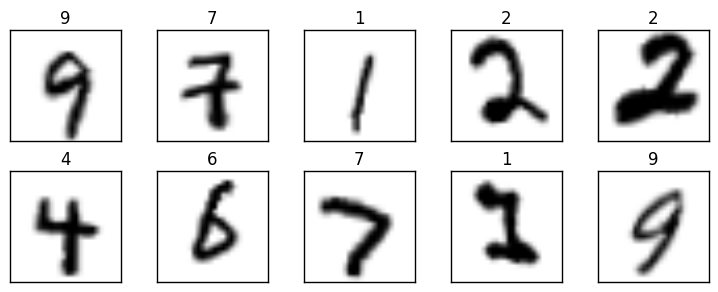

In [35]:
n = 10
X_distort = random_distortion(X_train[0:n,:], 36.0, 6.0, ix)
plot(X_train[0:n,:], np.argmax(y_train[:n,:], axis=1), ix)
plot(X_distort[0:n,:], np.argmax(y_train[:n,:], axis=1), ix)
plt.show()

In [36]:
n_loop = 9
res = np.empty([n_loop, int(split*features.shape[0]), num_classes])

#set up an array for the scores
score = np.empty(n_loop)


for i in range(n_loop):
    i_n = np.random.permutation(np.arange(X_train.shape[0]))
    X_scale_train = random_distortion(X_train, 36.0, 6.0, ix)
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #fit the model
    model.fit(X_scale_train[i_n,:],y_train[i_n,:],epochs=ne,validation_data=(X_test, y_test), batch_size=nb, verbose=0)
    res[i,:,:] = model.predict(X_test)
    scores = model.evaluate(X_test, y_test, verbose=0)
    score[i] = scores[1]*100.0
    print('Loop: ', i+1, 'Acc: %.3f%%' % (scores[1]*100))

    
print('')
print('Acc: %.3f%%' % (score.mean()))
print('s.d: %.3f%%' % (score.std()))

Loop:  1 Acc: 98.167%
Loop:  2 Acc: 98.548%
Loop:  3 Acc: 98.405%
Loop:  4 Acc: 98.310%
Loop:  5 Acc: 98.214%
Loop:  6 Acc: 98.333%
Loop:  7 Acc: 98.095%
Loop:  8 Acc: 98.190%
Loop:  9 Acc: 98.524%

Acc: 98.310%
s.d: 0.150%


In [37]:
result_majority = majority_voting(res)
result_mean     = mean_vote(res)
result_median   = median_vote(res)

print("majority voting: %.3f%%" % (score_votes(result_majority, y_test)))
print("mean vote:       %.3f%%" % (score_votes(result_mean, y_test)))
print("median vote:     %.3f%%" % (score_votes(result_median, y_test)))

majority voting: 98.929%
mean vote:       98.952%
median vote:     98.905%


Each of the three voting committees gives a results of about 98.9%, which is our best score yet.

Now we will use the same method, but with a more complex neural network.

We shall define a function which builds and compiles the network. This is taken from https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/ and contains:

1) Convolutional layer with 30 feature maps of size 5×5
   - creates a convolution kernal, convolves with the layer input to produced the output
   - 2d means that it is spatial
   - we set 30 output filters
   - we use a kernal of height and width 5 (5,5)<br><br>

2) Pooling layer taking the max over 2x2 patches
   - combines the outputs of one layer into a single neuron in the next layer
   - we will half it in each direction, so use (2,2)<br><br>
   
3) Convolutional layer with 15 feature maps of size 3×3.
   - the same as for the first layer, only now with smaller parameters<br><br>
   
4) Pooling layer taking the max over 2*2 patches
   - same as before<br><br>

5) Dropout layer with a probability of 20%
   - this randomly sets 20% of input units to be 0, with the aim of reducing overfitting<br><br>
    
6) Flatten layer
   - flattens the 4d array we input to a 1d array, so it can enter the final dense layers<br><br>
    
7) Fully connected layer with 128 neurons and rectifier activation
   - as Keras says "Just your regular densely-connected NN layer."<br><br>
    
8) Fully connected layer with 50 neurons and rectifier activation
   - still "just you standard regular densely-connected NN layer."<br><br>

9) Output layer
   - the final output layer, will return the predictions<br><br>
   
   
We will try different architectures later

In [38]:
def larger_model(ix, num_classes):
    # create model
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(1, ix, ix), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


First we try out the network on the basic data

In [40]:
model = larger_model(ix, num_classes)
features_2 = features.reshape(features.shape[0], 1, 28, 28).astype('float32')
model.fit(features_2,labels, validation_split=0.1, epochs=ne, batch_size=nb, verbose=1)

Train on 37800 samples, validate on 4200 samples
Epoch 1/100
37800/37800 [==============================] - 30s - loss: 0.8609 - acc: 0.7403 - val_loss: 0.2187 - val_acc: 0.9369
Epoch 2/100
37800/37800 [==============================] - 29s - loss: 0.2058 - acc: 0.9373 - val_loss: 0.1240 - val_acc: 0.9640
Epoch 3/100
37800/37800 [==============================] - 29s - loss: 0.1375 - acc: 0.9578 - val_loss: 0.0954 - val_acc: 0.9712
Epoch 4/100
37800/37800 [==============================] - 28s - loss: 0.1059 - acc: 0.9675 - val_loss: 0.0820 - val_acc: 0.9745
Epoch 5/100
37800/37800 [==============================] - 27s - loss: 0.0911 - acc: 0.9718 - val_loss: 0.0668 - val_acc: 0.9802
Epoch 6/100
37800/37800 [==============================] - 28s - loss: 0.0764 - acc: 0.9771 - val_loss: 0.0586 - val_acc: 0.9826
Epoch 7/100
37800/37800 [==============================] - 27s - loss: 0.0675 - acc: 0.9790 - val_loss: 0.0506 - val_acc: 0.9833
Epoch 8/100
37800/37800 [=======================

37800/37800 [==============================] - 27s - loss: 0.0073 - acc: 0.9974 - val_loss: 0.0233 - val_acc: 0.9933
Epoch 64/100
37800/37800 [==============================] - 27s - loss: 0.0100 - acc: 0.9964 - val_loss: 0.0250 - val_acc: 0.9917
Epoch 65/100
37800/37800 [==============================] - 27s - loss: 0.0069 - acc: 0.9975 - val_loss: 0.0238 - val_acc: 0.9933
Epoch 66/100
37800/37800 [==============================] - 28s - loss: 0.0073 - acc: 0.9974 - val_loss: 0.0238 - val_acc: 0.9936
Epoch 67/100
37800/37800 [==============================] - 27s - loss: 0.0065 - acc: 0.9976 - val_loss: 0.0265 - val_acc: 0.9938
Epoch 68/100
37800/37800 [==============================] - 28s - loss: 0.0079 - acc: 0.9972 - val_loss: 0.0281 - val_acc: 0.9921
Epoch 69/100
37800/37800 [==============================] - 27s - loss: 0.0064 - acc: 0.9976 - val_loss: 0.0274 - val_acc: 0.9926
Epoch 70/100
37800/37800 [==============================] - 28s - loss: 0.0062 - acc: 0.9980 - val_loss

The network gives an accuracy of about 99.1% after just 50 epochs, better than out committees did before. Also note that the accuracy for the training set is now less than 100% (which it was for the basic, single layer neural network), so the problem of overfitting has been reduced. 

Now we use this network with the committee method, using elastic distortions.

In [41]:
n_loop = 9
res = np.empty([n_loop, int(split*features.shape[0]), num_classes])

#set up an array for the scores
score = np.empty(n_loop)


for i in range(n_loop):
    i_n = np.random.permutation(np.arange(X_train.shape[0]))
    X_scale_train = random_distortion(X_train, 36.0, 6.0, ix)
    X_scale_train = X_scale_train.reshape(X_scale_train.shape[0], 1, ix, ix).astype('float32')
    X_scale_test = X_test.reshape(X_test.shape[0], 1, ix, ix).astype('float32')
    model = larger_model(ix, num_classes)
    #fit the model
    model.fit(X_scale_train[i_n,:],y_train[i_n,:],epochs=ne,validation_data=(X_scale_test, y_test), batch_size=nb, verbose=0)
    res[i,:,:] = model.predict(X_scale_test)
    scores = model.evaluate(X_scale_test, y_test, verbose=0)
    score[i] = scores[1]*100.0
    print('Loop: ', i+1, 'Acc: %.3f%%' % (scores[1]*100))

    
print('')
print('Acc: %.3f%%' % (score.mean()))
print('s.d: %.3f%%' % (score.std()))

Loop:  1 Acc: 99.167%
Loop:  2 Acc: 99.238%
Loop:  3 Acc: 99.286%
Loop:  4 Acc: 99.262%
Loop:  5 Acc: 99.333%
Loop:  6 Acc: 99.310%
Loop:  7 Acc: 99.167%
Loop:  8 Acc: 99.095%
Loop:  9 Acc: 99.286%

Acc: 99.238%
s.d: 0.074%


In [42]:
result_majority = majority_voting(res)
result_mean     = mean_vote(res)
result_median   = median_vote(res)

print("majority voting: %.3f%%" % (score_votes(result_majority, y_test)))
print("mean vote:       %.3f%%" % (score_votes(result_mean, y_test)))
print("median vote:     %.3f%%" % (score_votes(result_median, y_test)))

majority voting: 99.548%
mean vote:       99.571%
median vote:     99.571%


We get a score of about 99.6%, although now the median vote is slightly better than the others (perhaps we could take a committee of these three committees...). One way to improve this further is to get more data (which we can't easily do). However, since we now have worked out our methodology, we can run this on the entire data set (not just the train split).

We will also use more committee members (more votes always means smarter decisions, we hope ....)

But first, lets look at what we are getting wrong:

We will visualize each image that has been incorrectly labelled, with the plot title given as:- a: b,c,d
where a is the label, b is the guess using majortiy voting, c using mean and d using median votes

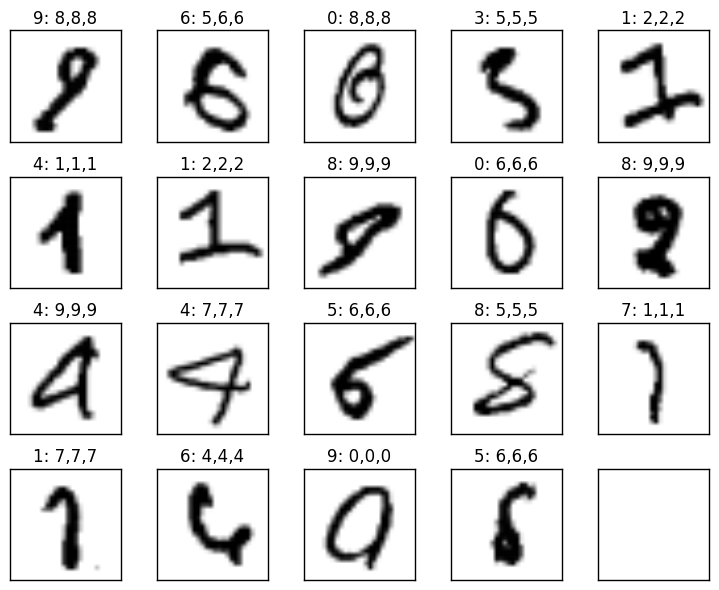

In [43]:
diff_majority = result_majority - np.argmax(y_test, axis=1)
diff_mean     = result_mean - np.argmax(y_test, axis=1)
diff_median   = result_median - np.argmax(y_test, axis=1)
index_majority = np.arange(len(y_test))[(diff_majority != 0)]
index_mean     = np.arange(len(y_test))[(diff_mean != 0)]
index_median   = np.arange(len(y_test))[(diff_median != 0)]
index = np.union1d(index_majority, index_mean)
index = np.union1d(index, index_median)
#print(index.shape)
#print(index)
#print(np.argmax(y_test[index], axis=1))
#print(np.intersect1d(index_majority, index_mean).shape)

#print(np.bincount(np.argmax(y_test, axis=1)[(diff_majority != 0)]))
#print(np.bincount(np.argmax(y_test, axis=1)[(diff_mean != 0)]))
#print(np.bincount(np.argmax(y_test, axis=1)[(diff_median != 0)]))

#plot(df_train.ix[:9, df_train.columns.str.contains("ixel")].values,
#     df_train.ix[:9, 'label'].astype(str), ix)

titles = np.core.defchararray.add(np.argmax(y_test[index], axis=1).astype(str), ': ')
titles = np.core.defchararray.add(titles, result_majority[index].astype(str))
titles = np.core.defchararray.add(titles, ',')
titles = np.core.defchararray.add(titles, result_mean[index].astype(str))
titles = np.core.defchararray.add(titles, ',')
titles = np.core.defchararray.add(titles, result_median[index].astype(str))

plot(X_test[index,:],titles, ix)
plt.show()

Some of these there is no helping ..

In [ ]:
n_loop = 15
res = np.empty([n_loop, int(features_test.shape[0]), num_classes])

for i in range(n_loop):
    i_n = np.random.permutation(np.arange(features.shape[0]))
    X_scale_train = random_distortion(features, 36.0, 6.0, ix)
    X_scale_train = X_scale_train.reshape(X_scale_train.shape[0], 1, ix, ix).astype('float32')
    X_scale_test = features_test.reshape(features_test.shape[0], 1, ix, ix).astype('float32')
    model = larger_model(ix, num_classes)
    model.fit(X_scale_train[i_n,:],labels[i_n,:], epochs=ne, batch_size=nb, verbose=1)
    res[i,:,:] = model.predict(X_scale_test)
    print('Loop: ', i+1)

Epoch 1/100
42000/42000 [==============================] - 29s - loss: 0.6014 - acc: 0.8074    
Epoch 2/100
42000/42000 [==============================] - 29s - loss: 0.1940 - acc: 0.9408    
Epoch 3/100
42000/42000 [==============================] - 29s - loss: 0.1418 - acc: 0.9560    
Epoch 4/100
42000/42000 [==============================] - 30s - loss: 0.1150 - acc: 0.9642    
Epoch 5/100
42000/42000 [==============================] - 29s - loss: 0.0963 - acc: 0.9698    
Epoch 6/100
42000/42000 [==============================] - 30s - loss: 0.0848 - acc: 0.9737    
Epoch 7/100
42000/42000 [==============================] - 29s - loss: 0.0763 - acc: 0.9756    
Epoch 8/100
42000/42000 [==============================] - 29s - loss: 0.0679 - acc: 0.9782    
Epoch 9/100
42000/42000 [==============================] - 28s - loss: 0.0631 - acc: 0.9801    
Epoch 10/100
42000/42000 [==============================] - 29s - loss: 0.0583 - acc: 0.9818    
Epoch 11/100
42000/42000 [=============

42000/42000 [==============================] - 28s - loss: 0.0097 - acc: 0.9966    
Epoch 70/100
42000/42000 [==============================] - 28s - loss: 0.0084 - acc: 0.9971    
Epoch 71/100
42000/42000 [==============================] - 28s - loss: 0.0116 - acc: 0.9960    
Epoch 72/100
42000/42000 [==============================] - 28s - loss: 0.0098 - acc: 0.9969    
Epoch 73/100
42000/42000 [==============================] - 29s - loss: 0.0098 - acc: 0.9966    
Epoch 74/100
42000/42000 [==============================] - 28s - loss: 0.0107 - acc: 0.9967    
Epoch 75/100
42000/42000 [==============================] - 28s - loss: 0.0100 - acc: 0.9967    
Epoch 76/100
42000/42000 [==============================] - 28s - loss: 0.0119 - acc: 0.9962    
Epoch 77/100
42000/42000 [==============================] - 29s - loss: 0.0094 - acc: 0.9970    
Epoch 78/100
42000/42000 [==============================] - 28s - loss: 0.0107 - acc: 0.9967    
Epoch 79/100
42000/42000 [=================

42000/42000 [==============================] - 28s - loss: 0.0176 - acc: 0.9940    
Epoch 38/100
42000/42000 [==============================] - 28s - loss: 0.0156 - acc: 0.9945    
Epoch 39/100
42000/42000 [==============================] - 28s - loss: 0.0157 - acc: 0.9946    
Epoch 40/100
42000/42000 [==============================] - 28s - loss: 0.0166 - acc: 0.9944    
Epoch 41/100
42000/42000 [==============================] - 28s - loss: 0.0153 - acc: 0.9944    
Epoch 42/100
42000/42000 [==============================] - 28s - loss: 0.0142 - acc: 0.9953    
Epoch 43/100
42000/42000 [==============================] - 28s - loss: 0.0137 - acc: 0.9954    
Epoch 44/100
42000/42000 [==============================] - 28s - loss: 0.0121 - acc: 0.9960    
Epoch 45/100
42000/42000 [==============================] - 28s - loss: 0.0131 - acc: 0.9954    
Epoch 46/100
42000/42000 [==============================] - 27s - loss: 0.0137 - acc: 0.9956    
Epoch 47/100
42000/42000 [=================

42000/42000 [==============================] - 28s - loss: 0.0952 - acc: 0.9700    
Epoch 6/100
42000/42000 [==============================] - 28s - loss: 0.0835 - acc: 0.9732    
Epoch 7/100
42000/42000 [==============================] - 29s - loss: 0.0760 - acc: 0.9755    
Epoch 8/100
42000/42000 [==============================] - 28s - loss: 0.0687 - acc: 0.9772    
Epoch 9/100
42000/42000 [==============================] - 28s - loss: 0.0609 - acc: 0.9805    
Epoch 10/100
42000/42000 [==============================] - 28s - loss: 0.0553 - acc: 0.9821    
Epoch 11/100
42000/42000 [==============================] - 29s - loss: 0.0547 - acc: 0.9824    
Epoch 12/100
42000/42000 [==============================] - 30s - loss: 0.0492 - acc: 0.9838    
Epoch 13/100
42000/42000 [==============================] - 30s - loss: 0.0478 - acc: 0.9849    
Epoch 14/100
42000/42000 [==============================] - 29s - loss: 0.0440 - acc: 0.9856    
Epoch 15/100
42000/42000 [=====================

And finally we output the data to submit to Kaggle

In [ ]:
result_mean = mean_vote(res)
result_median = median_vote(res)
result_majority = majority_voting(res)

pd.DataFrame({'ImageId':range(1,len(result_mean)+1), 
              'Label':result_mean}).to_csv("digit_predictions_mean.csv",  
                                                              index = False)
pd.DataFrame({'ImageId':range(1,len(result_median)+1), 
              'Label':result_median}).to_csv("digit_predictions_median.csv",  
                                                              index = False)
pd.DataFrame({'ImageId':range(1,len(result_majority)+1), 
              'Label':result_majority}).to_csv("digit_predictions_majority.csv",  
                                                              index = False)

Using the mean vote, we get a score of 99.557%.

Before we try to improve our network architecture, we will follow the advice of Andrew Ng who said "It's not who has the best algorithm that wins, it's who has the most data", and "collect" more data. 

Since we can't collect more samples, we will make a data set of the original data, concatonated on itself n times, and distort each entry so that the essentiall become different.

In [44]:
n = 10
res = np.empty([int(y_test.shape[0]), num_classes])
X_scale_train = np.concatenate((X_train,X_train))
y_scale_train = np.concatenate((y_train,y_train))
for i in range(1,n-1):
    X_scale_train = np.concatenate((X_scale_train,X_train))  #random_distortion(X_train, 36.0, 6.0, ix)
    y_scale_train = np.concatenate((y_scale_train,y_train))
 
print(X_scale_train.shape, X_train.shape)
i_n = np.random.permutation(np.arange(X_scale_train.shape[0]))
X_scale_train = random_distortion(X_scale_train, 36.0, 6.0, ix)
X_scale_train = X_scale_train.reshape(X_scale_train.shape[0], 1, ix, ix).astype('float32')
X_scale_test = X_test.reshape(X_test.shape[0], 1, ix, ix).astype('float32')
model = larger_model(ix, num_classes)
#fit the model
model.fit(X_scale_train[i_n,:],y_scale_train[i_n,:],epochs=ne,validation_data=(X_scale_test, y_test), batch_size=nb, verbose=1)
res[:,:] = model.predict(X_scale_test)
scores = model.evaluate(X_scale_test, y_test, verbose=0)
#score[i] = scores[1]*100.0
print('Acc: %.3f%%' % (scores[1]*100))

    
#print('')
#print('Acc: %.3f%%' % (score.mean()))
#print('s.d: %.3f%%' % (score.std()))



#model = larger_model(ix, num_classes)
#features_2 = 
#features_2 = features.reshape(features.shape[0], 1, 28, 28).astype('float32')
#model.fit(features_2,labels, validation_split=0.2, epochs=ne, batch_size=nb, verbose=1)

(378000, 784) (37800, 784)
Train on 378000 samples, validate on 4200 samples
Epoch 1/100
378000/378000 [==============================] - 276s - loss: 0.2475 - acc: 0.9207 - val_loss: 0.0325 - val_acc: 0.9888
Epoch 2/100
378000/378000 [==============================] - 261s - loss: 0.0742 - acc: 0.9766 - val_loss: 0.0250 - val_acc: 0.9910
Epoch 3/100
378000/378000 [==============================] - 259s - loss: 0.0539 - acc: 0.9832 - val_loss: 0.0195 - val_acc: 0.9933
Epoch 4/100
378000/378000 [==============================] - 272s - loss: 0.0442 - acc: 0.9860 - val_loss: 0.0186 - val_acc: 0.9921
Epoch 5/100
378000/378000 [==============================] - 274s - loss: 0.0370 - acc: 0.9881 - val_loss: 0.0216 - val_acc: 0.9929
Epoch 6/100
378000/378000 [==============================] - 272s - loss: 0.0322 - acc: 0.9896 - val_loss: 0.0180 - val_acc: 0.9940
Epoch 7/100
378000/378000 [==============================] - 272s - loss: 0.0289 - acc: 0.9906 - val_loss: 0.0177 - val_acc: 0.9945

KeyboardInterrupt: 

In [46]:
n_loop = 9
res = np.empty([n_loop, int(split*features.shape[0]), num_classes])
res_val = np.empty([n_loop, int(features_test.shape[0]), num_classes])

#set up an array for the scores
score = np.empty(n_loop)

n = 10
for i in range(n_loop):
    X_scale_train = np.concatenate((X_train,X_train))
    y_scale_train = np.concatenate((y_train,y_train))
    for j in range(1,n-1):
        X_scale_train = np.concatenate((X_scale_train,X_train))  #random_distortion(X_train, 36.0, 6.0, ix)
        y_scale_train = np.concatenate((y_scale_train,y_train))
    i_n = np.random.permutation(np.arange(X_scale_train.shape[0]))
    X_scale_train = random_distortion(X_scale_train, 36.0, 6.0, ix)
    X_scale_train = X_scale_train.reshape(X_scale_train.shape[0], 1, ix, ix).astype('float32')
    X_scale_test = X_test.reshape(X_test.shape[0], 1, ix, ix).astype('float32')
    X_scale_val = features_test.reshape(features_test.shape[0], 1, ix, ix).astype('float32')
    model = larger_model(ix, num_classes)
    #fit the model
    model.fit(X_scale_train[i_n,:],y_scale_train[i_n,:],epochs=20,validation_data=(X_scale_test, y_test), batch_size=nb, verbose=0)
    res[i,:,:] = model.predict(X_scale_test)
    res_val[i,:,:] = model.predict(X_scale_val)
    scores = model.evaluate(X_scale_test, y_test, verbose=0)
    score[i] = scores[1]*100.0
    print('Loop: ', i+1, 'Acc: %.3f%%' % (scores[1]*100))

    
print('')
print('Acc: %.3f%%' % (score.mean()))
print('s.d: %.3f%%' % (score.std()))

Loop:  1 Acc: 99.500%
Loop:  2 Acc: 99.548%
Loop:  3 Acc: 99.690%
Loop:  4 Acc: 99.500%
Loop:  5 Acc: 99.524%
Loop:  6 Acc: 99.476%
Loop:  7 Acc: 99.476%
Loop:  8 Acc: 99.405%
Loop:  9 Acc: 99.524%

Acc: 99.516%
s.d: 0.073%


In [47]:
result_majority = majority_voting(res)
result_mean     = mean_vote(res)
result_median   = median_vote(res)

print("majority voting: %.3f%%" % (score_votes(result_majority, y_test)))
print("mean vote:       %.3f%%" % (score_votes(result_mean, y_test)))
print("median vote:     %.3f%%" % (score_votes(result_median, y_test)))

majority voting: 99.667%
mean vote:       99.667%
median vote:     99.667%


In [48]:
result_mean = mean_vote(res_val)
result_median = median_vote(res_val)
result_majority = majority_voting(res_val)

pd.DataFrame({'ImageId':range(1,len(result_mean)+1), 
              'Label':result_mean}).to_csv("digit_predictions_mean.csv",  
                                                              index = False)
pd.DataFrame({'ImageId':range(1,len(result_median)+1), 
              'Label':result_median}).to_csv("digit_predictions_median.csv",  
                                                              index = False)
pd.DataFrame({'ImageId':range(1,len(result_majority)+1), 
              'Label':result_majority}).to_csv("digit_predictions_majority.csv",  
                                                              index = False)

We will now try to improve on the network architecture...

In [65]:
def larger_model_mk2(ix, num_classes):
    # create model
    model = Sequential()
    model.add(Conv2D(20, (5, 5), input_shape=(1, ix, ix), activation='tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)), )
    model.add(Conv2D(40, (4, 4), activation='tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(150, activation='tanh'))
    #model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [66]:
model = larger_model_mk2(ix, num_classes)
features_2 = features.reshape(features.shape[0], 1, 28, 28).astype('float32')
model.fit(features_2,labels, validation_split=0.2, epochs=ne*10, batch_size=nb, verbose=2)

Train on 33600 samples, validate on 8400 samples
Epoch 1/500
28s - loss: 0.4004 - acc: 0.8876 - val_loss: 0.1234 - val_acc: 0.9621
Epoch 2/500
28s - loss: 0.1105 - acc: 0.9676 - val_loss: 0.0742 - val_acc: 0.9751
Epoch 3/500
28s - loss: 0.0779 - acc: 0.9759 - val_loss: 0.0554 - val_acc: 0.9821
Epoch 4/500
28s - loss: 0.0622 - acc: 0.9813 - val_loss: 0.0490 - val_acc: 0.9844
Epoch 5/500
28s - loss: 0.0508 - acc: 0.9846 - val_loss: 0.0459 - val_acc: 0.9852
Epoch 6/500
28s - loss: 0.0431 - acc: 0.9865 - val_loss: 0.0421 - val_acc: 0.9868
Epoch 7/500
28s - loss: 0.0388 - acc: 0.9879 - val_loss: 0.0394 - val_acc: 0.9880
Epoch 8/500
28s - loss: 0.0311 - acc: 0.9898 - val_loss: 0.0399 - val_acc: 0.9873
Epoch 9/500
28s - loss: 0.0266 - acc: 0.9918 - val_loss: 0.0384 - val_acc: 0.9874
Epoch 10/500
28s - loss: 0.0265 - acc: 0.9918 - val_loss: 0.0350 - val_acc: 0.9898
Epoch 11/500
28s - loss: 0.0224 - acc: 0.9931 - val_loss: 0.0475 - val_acc: 0.9861
Epoch 12/500
28s - loss: 0.0187 - acc: 0.9943 -

29s - loss: 0.0029 - acc: 0.9988 - val_loss: 0.0452 - val_acc: 0.9907
Epoch 101/500
29s - loss: 0.0017 - acc: 0.9994 - val_loss: 0.0456 - val_acc: 0.9901
Epoch 102/500
29s - loss: 0.0024 - acc: 0.9992 - val_loss: 0.0481 - val_acc: 0.9896
Epoch 103/500
29s - loss: 0.0018 - acc: 0.9994 - val_loss: 0.0447 - val_acc: 0.9900
Epoch 104/500
29s - loss: 0.0015 - acc: 0.9996 - val_loss: 0.0481 - val_acc: 0.9907
Epoch 105/500
29s - loss: 0.0023 - acc: 0.9993 - val_loss: 0.0518 - val_acc: 0.9898
Epoch 106/500
29s - loss: 0.0025 - acc: 0.9992 - val_loss: 0.0514 - val_acc: 0.9904
Epoch 107/500
29s - loss: 0.0019 - acc: 0.9996 - val_loss: 0.0488 - val_acc: 0.9910
Epoch 108/500
29s - loss: 0.0031 - acc: 0.9992 - val_loss: 0.0491 - val_acc: 0.9900
Epoch 109/500
29s - loss: 0.0015 - acc: 0.9996 - val_loss: 0.0454 - val_acc: 0.9904
Epoch 110/500
29s - loss: 0.0014 - acc: 0.9996 - val_loss: 0.0452 - val_acc: 0.9905
Epoch 111/500
29s - loss: 0.0014 - acc: 0.9996 - val_loss: 0.0452 - val_acc: 0.9902
Epoch 

29s - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0531 - val_acc: 0.9907
Epoch 199/500
29s - loss: 0.0017 - acc: 0.9994 - val_loss: 0.0521 - val_acc: 0.9900
Epoch 200/500
29s - loss: 0.0023 - acc: 0.9993 - val_loss: 0.0514 - val_acc: 0.9895
Epoch 201/500
29s - loss: 0.0014 - acc: 0.9995 - val_loss: 0.0518 - val_acc: 0.9899
Epoch 202/500
29s - loss: 0.0012 - acc: 0.9996 - val_loss: 0.0514 - val_acc: 0.9896
Epoch 203/500
29s - loss: 0.0016 - acc: 0.9994 - val_loss: 0.0510 - val_acc: 0.9904
Epoch 204/500
29s - loss: 7.4005e-04 - acc: 0.9997 - val_loss: 0.0590 - val_acc: 0.9893
Epoch 205/500
29s - loss: 0.0015 - acc: 0.9995 - val_loss: 0.0509 - val_acc: 0.9905
Epoch 206/500
29s - loss: 0.0023 - acc: 0.9992 - val_loss: 0.0609 - val_acc: 0.9898
Epoch 207/500
29s - loss: 0.0021 - acc: 0.9992 - val_loss: 0.0508 - val_acc: 0.9905
Epoch 208/500
29s - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0526 - val_acc: 0.9898
Epoch 209/500
29s - loss: 0.0011 - acc: 0.9996 - val_loss: 0.0508 - val_acc: 0.9898
Ep

29s - loss: 0.0015 - acc: 0.9995 - val_loss: 0.0541 - val_acc: 0.9892
Epoch 296/500
29s - loss: 0.0012 - acc: 0.9995 - val_loss: 0.0523 - val_acc: 0.9908
Epoch 297/500
31s - loss: 9.3262e-04 - acc: 0.9997 - val_loss: 0.0552 - val_acc: 0.9904
Epoch 298/500
30s - loss: 0.0020 - acc: 0.9993 - val_loss: 0.0534 - val_acc: 0.9901
Epoch 299/500
30s - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0550 - val_acc: 0.9898
Epoch 300/500
30s - loss: 0.0015 - acc: 0.9995 - val_loss: 0.0530 - val_acc: 0.9907
Epoch 301/500
30s - loss: 0.0019 - acc: 0.9993 - val_loss: 0.0502 - val_acc: 0.9905
Epoch 302/500
30s - loss: 0.0015 - acc: 0.9995 - val_loss: 0.0547 - val_acc: 0.9896
Epoch 303/500
30s - loss: 0.0021 - acc: 0.9992 - val_loss: 0.0527 - val_acc: 0.9902
Epoch 304/500
30s - loss: 0.0015 - acc: 0.9996 - val_loss: 0.0552 - val_acc: 0.9890
Epoch 305/500
30s - loss: 9.3071e-04 - acc: 0.9998 - val_loss: 0.0516 - val_acc: 0.9901
Epoch 306/500
31s - loss: 0.0013 - acc: 0.9995 - val_loss: 0.0545 - val_acc: 0.989

29s - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0591 - val_acc: 0.9895
Epoch 393/500
29s - loss: 0.0014 - acc: 0.9995 - val_loss: 0.0564 - val_acc: 0.9895
Epoch 394/500
29s - loss: 0.0016 - acc: 0.9995 - val_loss: 0.0623 - val_acc: 0.9893
Epoch 395/500
29s - loss: 0.0013 - acc: 0.9995 - val_loss: 0.0551 - val_acc: 0.9908
Epoch 396/500
29s - loss: 0.0012 - acc: 0.9996 - val_loss: 0.0565 - val_acc: 0.9905
Epoch 397/500
29s - loss: 0.0014 - acc: 0.9996 - val_loss: 0.0590 - val_acc: 0.9906
Epoch 398/500
29s - loss: 9.0421e-04 - acc: 0.9997 - val_loss: 0.0535 - val_acc: 0.9900
Epoch 399/500
29s - loss: 0.0012 - acc: 0.9995 - val_loss: 0.0555 - val_acc: 0.9907
Epoch 400/500
29s - loss: 9.6614e-04 - acc: 0.9997 - val_loss: 0.0592 - val_acc: 0.9900
Epoch 401/500
29s - loss: 0.0019 - acc: 0.9994 - val_loss: 0.0624 - val_acc: 0.9896
Epoch 402/500
29s - loss: 0.0017 - acc: 0.9996 - val_loss: 0.0622 - val_acc: 0.9894
Epoch 403/500
29s - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0567 - val_acc: 0.991

31s - loss: 9.8639e-04 - acc: 0.9997 - val_loss: 0.0593 - val_acc: 0.9906
Epoch 490/500
31s - loss: 9.7077e-04 - acc: 0.9998 - val_loss: 0.0577 - val_acc: 0.9910
Epoch 491/500
31s - loss: 9.3053e-04 - acc: 0.9996 - val_loss: 0.0579 - val_acc: 0.9899
Epoch 492/500
30s - loss: 8.8548e-04 - acc: 0.9997 - val_loss: 0.0578 - val_acc: 0.9904
Epoch 493/500
31s - loss: 9.8286e-04 - acc: 0.9998 - val_loss: 0.0619 - val_acc: 0.9906
Epoch 494/500
31s - loss: 0.0011 - acc: 0.9996 - val_loss: 0.0582 - val_acc: 0.9904
Epoch 495/500
30s - loss: 8.4748e-04 - acc: 0.9998 - val_loss: 0.0626 - val_acc: 0.9899
Epoch 496/500
31s - loss: 5.9281e-04 - acc: 0.9999 - val_loss: 0.0570 - val_acc: 0.9907
Epoch 497/500
31s - loss: 8.8887e-04 - acc: 0.9997 - val_loss: 0.0618 - val_acc: 0.9901
Epoch 498/500
30s - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0577 - val_acc: 0.9908
Epoch 499/500
30s - loss: 0.0013 - acc: 0.9997 - val_loss: 0.0581 - val_acc: 0.9895
Epoch 500/500
31s - loss: 7.2920e-04 - acc: 0.9998 - val_l

In [67]:
n_loop = 9
res = np.empty([n_loop, int(split*features.shape[0]), num_classes])

#set up an array for the scores
score = np.empty(n_loop)


for i in range(n_loop):
    i_n = np.random.permutation(np.arange(X_train.shape[0]))
    X_scale_train = random_distortion(X_train, 36.0, 6.0, ix)
    X_scale_train = X_scale_train.reshape(X_scale_train.shape[0], 1, ix, ix).astype('float32')
    X_scale_test = X_test.reshape(X_test.shape[0], 1, ix, ix).astype('float32')
    model = larger_model_mk2(ix, num_classes)
    #fit the model
    model.fit(X_scale_train[i_n,:],y_train[i_n,:],epochs=ne,validation_data=(X_scale_test, y_test), batch_size=nb, verbose=0)
    res[i,:,:] = model.predict(X_scale_test)
    scores = model.evaluate(X_scale_test, y_test, verbose=0)
    score[i] = scores[1]*100.0
    print('Loop: ', i+1, 'Acc: %.3f%%' % (scores[1]*100))

    
print('')
print('Acc: %.3f%%' % (score.mean()))
print('s.d: %.3f%%' % (score.std()))

Loop:  1 Acc: 98.952%
Loop:  2 Acc: 98.905%
Loop:  3 Acc: 99.012%
Loop:  4 Acc: 98.952%
Loop:  5 Acc: 98.893%
Loop:  6 Acc: 98.952%
Loop:  7 Acc: 98.976%
Loop:  8 Acc: 98.940%
Loop:  9 Acc: 98.762%

Acc: 98.927%
s.d: 0.067%
